# EMO - reservoir meteorology
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 04-09-2024<br>

**Introduction:**<br>

This code extracts the precipitation and open water evaporation time series from the EMO1 dataset. It's simply a specific application of the tool `ncextract` in the `lisflood-utilities` repository. I had to do it because the tool returned errors reading some of the NetCDF files.

In [3]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

from lisfloodreservoirs.utils import DatasetConfig

### Configuration

In [4]:
# read dataset configuration file
cfg = DatasetConfig('config_dataset.yml')

# variable
var = 'pr'#'e0'

# path where the original timeseries are stored
path_ts = cfg.PATH_LISFLOOD / 'iberia' / 'meteo' / var

# directory of the ResOpsES data set
PATH_AUX = cfg.PATH_RESOPS / 'ancillary' / 'ncextract'
PATH_OUT = PATH_AUX / var
PATH_OUT.mkdir(parents=True, exist_ok=True)

print(f'Extracted time series will be saved in {PATH_OUT}')

Extracted time series will be saved in Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsES\ancillary\ncextract\pr


### Reservoirs

305 reservoirs


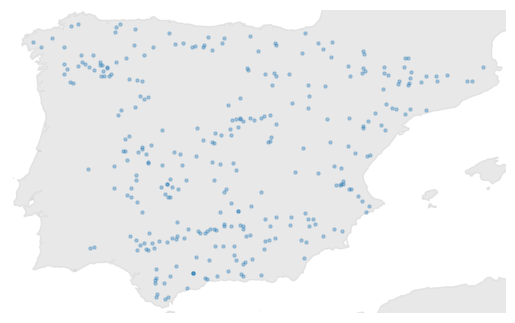

In [5]:
# import shapefile
resops = gpd.read_file(PATH_AUX / 'reservoirs.shp')
resops[['LAT', 'LON']] = resops[['LAT', 'LON']].astype(float)

# convert to DataArray of point coordinates
points = resops.set_index('SNCZI')[['LAT', 'LON']].to_xarray()
n_reservoirs = len(points.LAT)
print(f'{n_reservoirs} reservoirs')

# plot reservoir locations
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
ax.scatter(points.LON, points.LAT, s=5, alpha=.3)
ax.set_aspect('equal')
ax.axis('off');

### Time series of reservoir storage

In [4]:
# read
PATH_TS = cfg.PATH_LISFLOOD / 'iberia' / 'meteo' / var
ds = xr.open_mfdataset(f'{PATH_TS}/EMO-1arcmin-{var}_*.nc', chunks='auto', parallel=True)

# I substract 12 hours from the original 'time' dimension
# 1. 6 h because we discovered an error in the storage of the EFAS data in the Climate Data Store
# 2. 6 h to convert the end-of-timestep convention into start-of timestep, so I can apply `resample`
ds['time'] = ds['time'] - pd.Timedelta(hours=12)

# resample to daily resolution
ds = ds.resample(time='1D').mean()

# extract points of interest
ds_poi = ds.sel(lat=points.LAT, lon=points.LON, method='nearest').compute()

In [5]:
# export
for ID in tqdm(ds_poi.SNCZI.data):
    fileout = PATH_OUT / f'{ID:04}.nc'
    ds_poi.sel(SNCZI=ID).to_netcdf(fileout)

  0%|          | 0/305 [00:00<?, ?it/s]